<a href="https://www.kaggle.com/code/muichimon/swin-rsna-pneumonia-ipynb?scriptVersionId=293343753" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Set-Up**

In [1]:
%pip install torchio --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.3/194.3 kB 6.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
import torchio as tio 
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import math
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import trange, tqdm
from pathlib import Path
from tqdm import tqdm

%matplotlib inline

# **Pre-Processing**

In [3]:
labels_df = pd.read_csv(
    "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv"
)

labels_df = labels_df.groupby("patientId")["Target"].max().reset_index()

print(labels_df["Target"].value_counts())
print(labels_df.info(verbose=True, show_counts=True))

Target
0    20672
1     6012
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26684 entries, 0 to 26683
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  26684 non-null  object
 1   Target     26684 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 417.1+ KB
None


In [4]:
labels_df.head()

,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
1,000924cf-0f8d-42bd-9158-1af53881a557,0
2,000db696-cf54-4385-b10b-6b16fbb3f985,1
3,000fe35a-2649-43d4-b027-e67796d412e0,1
4,001031d9-f904-4a23-b3e5-2c088acd19c6,1


## Subjects

In [5]:
ROOT_PATH = Path("/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/")
patient_dirs = list(ROOT_PATH.glob("*"))

patient_dirs[0] # debug

PosixPath('/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/c3b05294-29be-46e4-8a51-96fd211e4ca5.dcm')

In [6]:
def get_patient_label(patient_path: Path, labels_df: pd.DataFrame) -> int:
    patientID = patient_path.stem
    label = labels_df.loc[labels_df["patientId"] == patientID, "Target"]
    label = label.iloc[0] if not label.empty else None
    return int(label)

In [7]:
subjects = []
heights = []
widths = []
labels = []

for subject_path in tqdm(patient_dirs):
    
    img_path = subject_path
    label = get_patient_label(subject_path, labels_df)

    ct = tio.ScalarImage(img_path)
    h, w, _ = ct.spatial_shape   

    subject = tio.Subject(
        CT = ct,
        Label = torch.tensor(label, dtype=torch.long),
        PatientID = subject_path.stem
    )

    subjects.append(subject)
    heights.append(h)
    widths.append(w)
    labels.append(label)

100%|██████████| 26684/26684 [05:25<00:00, 82.01it/s]


In [8]:
print(type(subjects[15]["CT"]), subjects[15]["CT"])
print(type(subjects[15]["Label"]), subjects[15]["Label"])
subjects[15]["CT"].spatial_shape

<class 'torchio.data.image.ScalarImage'> ScalarImage(shape: (1, 1024, 1024, 1); spacing: (0.17, 0.17, 1.00); orientation: LPS+; path: "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/7625412b-fbb0-46d7-9f7d-00b436cc467a.dcm")
<class 'torch.Tensor'> tensor(1)


(1024, 1024, 1)

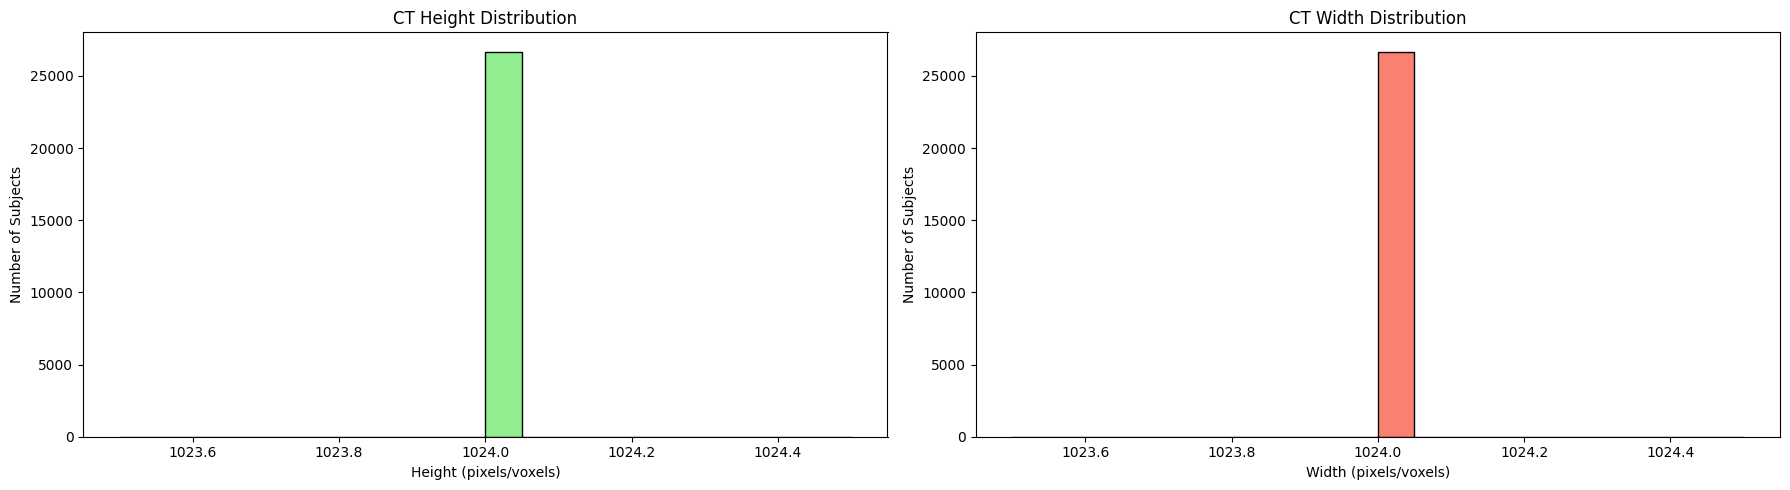

In [9]:
plt.figure(figsize=(18,5))

# Plot height
plt.subplot(1,2,1)
plt.hist(heights, bins=20, color='lightgreen', edgecolor='black')
plt.title("CT Height Distribution")
plt.xlabel("Height (pixels/voxels)")
plt.ylabel("Number of Subjects")

# Plot width
plt.subplot(1,2,2)
plt.hist(widths, bins=20, color='salmon', edgecolor='black')
plt.title("CT Width Distribution")
plt.xlabel("Width (pixels/voxels)")
plt.ylabel("Number of Subjects")

plt.tight_layout()
plt.show()

## **Transforms**

In [10]:
process = tio.Compose([
    tio.ToCanonical(), # step 1: fix orientation - RAS              
    tio.RescaleIntensity((0, 1)), # step 2: normalize intensity
    tio.Resize((356, 356, 1)),
    tio.CropOrPad((256, 256, 1)),          
])

augmentation = tio.RandomAffine(scales=(0.9, 1.1), degrees=(-10, 10))

train_transform = tio.Compose([process, augmentation])
val_transform = tio.Compose([process])

## **DataSet & DataLoader**

In [11]:
from sklearn.model_selection import train_test_split

# (90/10)
train_val_subjects, test_subjects = train_test_split(
    subjects,
    test_size=0.15,
    stratify=labels,
    random_state=42
)

# (80/20)
train_subjects, val_subjects = train_test_split(
    train_val_subjects,
    test_size=0.2,
    stratify=[s.Label.item() for s in train_val_subjects],
    random_state=42
)

# Verify class distributions
train_labels = [s.Label.item() for s in train_subjects]
val_labels   = [s.Label.item() for s in val_subjects]
test_labels  = [s.Label.item() for s in test_subjects]

print("Train counts:", np.bincount(train_labels))
print("Val counts:", np.bincount(val_labels))
print("Test counts:", np.bincount(test_labels))

Train counts: [14056  4088]
Val counts: [3515 1022]
Test counts: [3101  902]


In [12]:
train_dataset = tio.SubjectsDataset(train_subjects, transform = train_transform) 
val_dataset = tio.SubjectsDataset(val_subjects, transform = val_transform)  
test_dataset = tio.SubjectsDataset(test_subjects, transform = val_transform)  

In [13]:
from typing import Tuple, List

def collate_subjects(batch: List) -> Tuple[torch.Tensor, torch.Tensor]:
    images = torch.stack([s.CT.data.squeeze(-1) for s in batch])
    labels = torch.tensor([s.Label.item() for s in batch])
    return images, labels

In [14]:
train_loader = DataLoader(train_dataset, batch_size=64, num_workers=4, collate_fn=collate_subjects, shuffle=True, pin_memory = True)
val_loader = DataLoader(val_dataset, batch_size=64, num_workers=4, collate_fn=collate_subjects)
test_loader = DataLoader(test_dataset, batch_size=64, num_workers=4, collate_fn=collate_subjects)

In [15]:
x, y = next(iter(train_loader))
print(f"Images shape fresh off the loader: {x.shape}")
print(f"Labels shape fresh off the loader: {y.shape}")
print(f"Labels corresponding to {y.shape[0]} images in the batch: " + str(y))

Images shape fresh off the loader: torch.Size([64, 1, 256, 256])
Labels shape fresh off the loader: torch.Size([64])
Labels corresponding to 64 images in the batch: tensor([0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])


# **Model**

<div style="background-color: white; padding: 15px; display: inline-block;">
    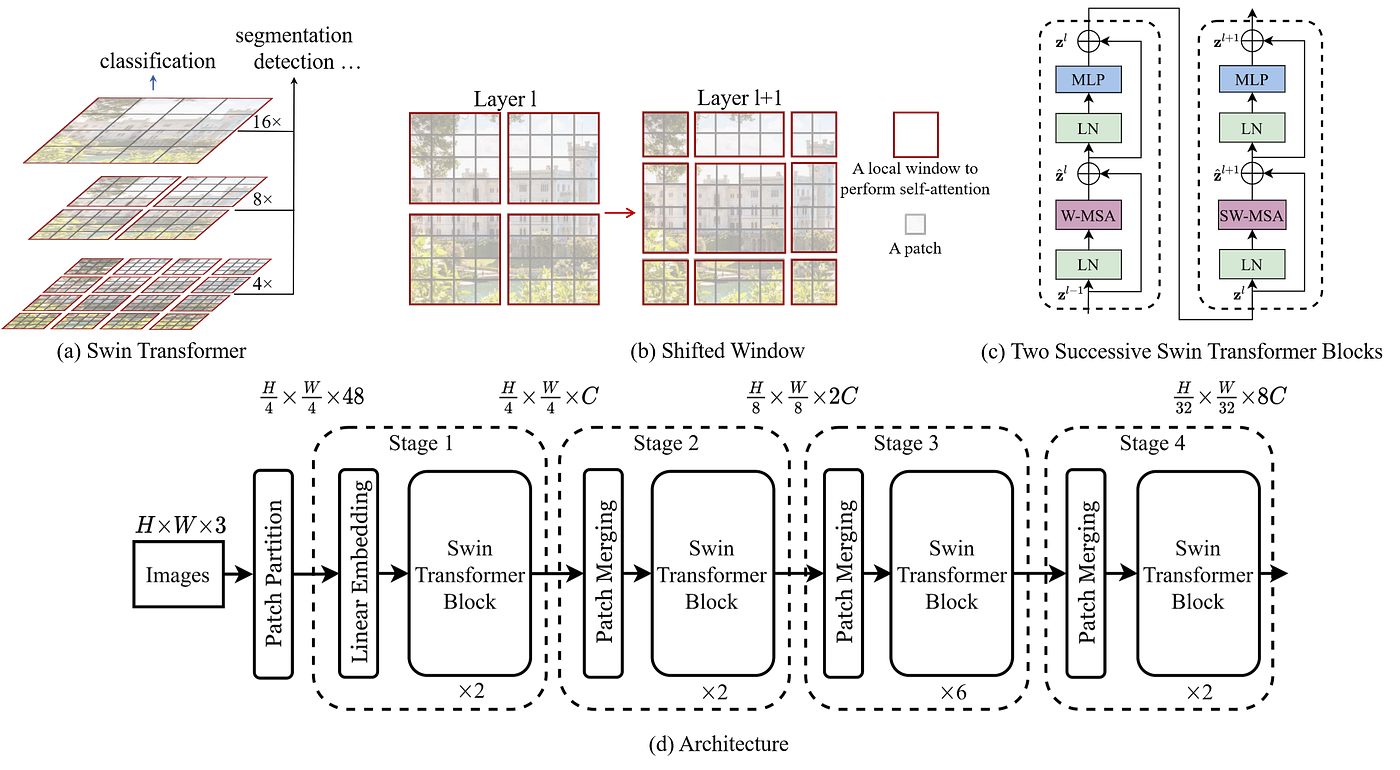
</div>

In [16]:
# =========================
# Model / Training Config
# =========================

patch_size = 16          # 256 / 16 = 16 tokens per axis
win_size = 4             # MUST divide 16 and be even
attention_heads = 4      # hidden_size % heads == 0
hidden_size = 32         # embedding dimension

LEARNING_RATE = 3e-4

# =========================
# Derived from data
# =========================

img_size = x.shape[2]    # 256
channels_in = x.shape[1] # 1 (grayscale)
num_classes = 1          # binary classification

print(f"Image Size: {img_size}")
print(f"Input Channels: {channels_in}")
print(f"Output Classes: {num_classes}")

Image Size: 256
Input Channels: 1
Output Classes: 1


## **Patch Embedding**

In [17]:
class PatchEmbedding(nn.Module):
    def __init__(self, channels_in, channels_out, patch_size):
        super().__init__()
        self.patch_size = patch_size

        self.proj = nn.Conv2d(
            channels_in,
            channels_out,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x):
        # x: (B, C, H, W)
        x = self.proj(x)
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # (B, H*W, C)
        return x, H, W

## **Window Functions**

In [18]:
def window_partition(x, win_size):
    B, H, W, C = x.shape
    x = x.view(B, H // win_size, win_size, W // win_size, win_size, C)
    x = x.permute(0, 1, 3, 2, 4, 5)
    return x.reshape(-1, win_size, win_size, C)


def window_reverse(windows, win_size, H, W):
    B = int(windows.shape[0] // ((H // win_size) * (W // win_size)))
    x = windows.view(B, H // win_size, W // win_size, win_size, win_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5)
    return x.reshape(B, H, W, -1)

In [19]:
#@description Compute attention score for each window
class WindowAttention(nn.Module):
    def __init__(self, dim, num_heads, win_size):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        self.win_size = win_size

        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)

        coords = torch.stack(
            torch.meshgrid(
                torch.arange(win_size),
                torch.arange(win_size),
                indexing='ij'
            )
        )
        coords_flat = coords.flatten(1)
        rel = coords_flat[:, :, None] - coords_flat[:, None, :]
        rel = rel.permute(1, 2, 0)

        rel[:, :, 0] += win_size - 1
        rel[:, :, 0] *= 2 * win_size - 1
        rel[:, :, 1] += win_size - 1

        self.register_buffer("pos_index", rel.sum(-1))

        self.rel_bias = nn.Parameter(
            torch.zeros((2 * win_size - 1) ** 2, num_heads)
        )

    def forward(self, x, mask=None):
        B_, N, C = x.shape

        qkv = self.qkv(x).reshape(
            B_, N, 3, self.num_heads, self.head_dim
        ).permute(2, 0, 3, 1, 4)

        q, k, v = qkv
        q = q * self.scale

        attn = q @ k.transpose(-2, -1)

        rel_bias = self.rel_bias[self.pos_index.view(-1)].view(
            N, N, -1
        ).permute(2, 0, 1)

        attn = attn + rel_bias.unsqueeze(0)

        if mask is not None:
            num_win = mask.shape[0]
            attn = attn.view(B_ // num_win, num_win, self.num_heads, N, N)
            attn = attn + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)

        attn = attn.softmax(dim=-1)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        return self.proj(x)

## **SWIN Block**

In [20]:
#@title SWIN Block
class SwinBlock(nn.Module):
    def __init__(self, dim, res, win_size, shift, heads):
        super().__init__()
        self.dim = dim
        self.res = res
        self.win_size = win_size
        self.shift = shift
        self.heads = heads

        self.norm1 = nn.LayerNorm(dim)
        self.attn = WindowAttention(dim, heads, win_size)

        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, 4 * dim),
            nn.GELU(),
            nn.Linear(4 * dim, dim)
        )

        self.mask = None  # ← created lazily

    def create_mask(self, H, W, device):
        img_mask = torch.zeros((1, H, W, 1), device=device)
        cnt = 0

        for h in (slice(0, -self.win_size),
                  slice(-self.win_size, -self.shift),
                  slice(-self.shift, None)):
            for w in (slice(0, -self.win_size),
                      slice(-self.win_size, -self.shift),
                      slice(-self.shift, None)):
                img_mask[:, h, w, :] = cnt
                cnt += 1

        mask = window_partition(img_mask, self.win_size)
        mask = mask.view(-1, self.win_size * self.win_size)
        mask = mask.unsqueeze(1) - mask.unsqueeze(2)
        return mask.masked_fill(mask != 0, -100.0)

    def forward(self, x):
        B, L, C = x.shape
        H, W = self.res

        # Lazily create mask once per resolution
        if self.shift > 0 and (
            self.mask is None
            or self.mask.device != x.device
        ):
            self.mask = self.create_mask(H, W, x.device)

        shortcut = x
        x = self.norm1(x).view(B, H, W, C)

        if self.shift > 0:
            x = torch.roll(x, (-self.shift, -self.shift), (1, 2))

        x = window_partition(x, self.win_size)
        x = x.view(-1, self.win_size * self.win_size, C)

        x = self.attn(x, self.mask if self.shift > 0 else None)

        x = window_reverse(x, self.win_size, H, W)

        if self.shift > 0:
            x = torch.roll(x, (self.shift, self.shift), (1, 2))

        x = shortcut + x.view(B, L, C)
        x = x + self.mlp(self.norm2(x))
        return x

## **Patch Merging**

In [21]:
#@title Patch Merging
class PatchMerging(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = nn.LayerNorm(4 * dim)

    def forward(self, x, H, W):
        B, L, C = x.shape
        assert L == H * W, "Input feature has wrong size"

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]

        x = torch.cat([
            x0.reshape(B, -1, C),
            x1.reshape(B, -1, C),
            x2.reshape(B, -1, C),
            x3.reshape(B, -1, C)
        ], dim=-1)

        x = self.norm(x)
        x = self.reduction(x)

        return x, H // 2, W // 2

In [22]:
class TwoStageSwinTransformer(nn.Module):
    def __init__(
        self,
        channels_in,
        embed_dim,
        num_classes,
        heads,
        win_size,
        patch_size
    ):
        super().__init__()

        self.win_size = win_size

        # Patch embedding
        self.patch_embed = PatchEmbedding(
            channels_in=channels_in,
            channels_out=embed_dim,
            patch_size=patch_size
        )

        # -------- Stage 1 --------
        self.stage1_blocks = nn.ModuleList([
            SwinBlock(
                dim=embed_dim,
                res=(0, 0),          # placeholder, updated in forward
                win_size=win_size,
                shift=0,
                heads=heads
            ),
            SwinBlock(
                dim=embed_dim,
                res=(0, 0),
                win_size=win_size,
                shift=win_size // 2,
                heads=heads
            ),
        ])

        # Patch merging
        self.patch_merge = PatchMerging(embed_dim)

        merged_dim = embed_dim * 2
        heads_stage2 = heads * 2

        # -------- Stage 2 --------
        self.stage2_blocks = nn.ModuleList([
            SwinBlock(
                dim=merged_dim,
                res=(0, 0),
                win_size=win_size // 2,
                shift=0,
                heads=heads_stage2
            ),
            SwinBlock(
                dim=merged_dim,
                res=(0, 0),
                win_size=win_size // 2,
                shift=(win_size // 2) // 2,
                heads=heads_stage2
            ),
        ])

        self.norm = nn.LayerNorm(merged_dim)
        self.fc = nn.Linear(merged_dim, num_classes)

    def forward(self, x):
        # Patch embedding
        x, H, W = self.patch_embed(x)

        # -------- Stage 1 --------
        for blk in self.stage1_blocks:
            blk.res = (H, W)
            x = blk(x)

        # Patch merging
        x, H, W = self.patch_merge(x, H, W)

        # -------- Stage 2 --------
        for blk in self.stage2_blocks:
            blk.res = (H, W)
            x = blk(x)

        # Head
        x = self.norm(x)
        x = x.mean(dim=1)  # GAP
        x = self.fc(x)

        return x

# **Train**

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TwoStageSwinTransformer(
    channels_in=channels_in,
    embed_dim=hidden_size,
    num_classes=num_classes,
    heads=attention_heads,
    win_size=win_size,
    patch_size=patch_size
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

In [24]:
# print(model)
x = torch.randn(8, 1, 256, 256).to(device) 
y = model(x)
print(y.shape)
print(f"How likely (logits) the model predicts each image in the batch to be pneumonic: \n{y}")
# y.argmax(dim=0)

print("Our batch size is 64, yet this works. batch size can be <= 64")

torch.Size([8, 1])
How likely (logits) the model predicts each image in the batch to be pneumonic: 
tensor([[-0.1183],
        [ 0.0111],
        [-0.0098],
        [ 0.2793],
        [ 0.1383],
        [-0.0607],
        [-0.0223],
        [-0.0366]], device='cuda:0', grad_fn=<AddmmBackward0>)
Our batch size is 64, yet this works. batch size can be <= 64


In [25]:
num_model_params = 0
for param in model.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 142777 (Approximately 0 Million) Parameters!


In [26]:
from sklearn.metrics import accuracy_score, roc_curve, auc
import time

In [27]:
def validate(model, val_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)  # (B,1)

            logits = model(images)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).long()

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu().long())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    val_acc = accuracy_score(
        all_labels.numpy(),
        all_preds.numpy()
    ) * 100

    return val_acc

In [28]:
epochs = 30

patience = 5
tolerance = 0.005

best_val_acc = 0.0
stale_epochs = 0

print("Training started...")
for epoch in range(epochs):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    START = time.time()
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        labels = labels.float().unsqueeze(1)  # (B,1)

        optimizer.zero_grad()
        logits = model(images)                 # (B,1)
        
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # --- compute predictions ---
        probs = torch.sigmoid(logits)          # (B,1)
        preds = (probs > 0.5).long()           # binary 0/1
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu().long())

    TRAIN_TIME = time.time()
    # --- epoch metrics ---
    all_preds_tensor = torch.cat(all_preds, dim=0)
    all_labels_tensor = torch.cat(all_labels, dim=0)

    epoch_acc = accuracy_score(all_labels_tensor.numpy(), all_preds_tensor.numpy()) * 100

    # ---- validation ----
    val_acc = validate(model, val_loader, device)
    VAL_TIME = time.time()

    print(
        f"===> Epoch {epoch+1}: "
        f"Loss = {total_loss:.4f} | "
        f"Epoch Acc = {epoch_acc:.2f}% | "
        f"Val Acc = {val_acc:.2f}%"
    )

    # ---- early stopping ----
    if val_acc > best_val_acc + tolerance:
        best_val_acc = val_acc
        stale_epochs = 0

        torch.save(
            {
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "val_acc": best_val_acc,
                "loss": total_loss,
            },
            "best_model.pth"
        )
    
        print(f"Validation improved to {best_val_acc:.2f}%")
    else:
        stale_epochs += 1
        print(f"No significant improvement ({stale_epochs}/{patience})")

    if stale_epochs >= patience:
        print("Early stopping triggered.")
        break

    print(f"Train time: {int((TRAIN_TIME - START)/60.0)}.{int((TRAIN_TIME - START)%60.0)} mins | Val time: {int((VAL_TIME - TRAIN_TIME)/60.0)}.{int((VAL_TIME - TRAIN_TIME)%60.0)} mins")

Training started...
===> Epoch 1: Loss = 149.9933 | Epoch Acc = 77.24% | Val Acc = 77.72%
Validation improved to 77.72%
Train time: 7.39 mins | Val time: 1.55 mins
===> Epoch 2: Loss = 131.0071 | Epoch Acc = 78.68% | Val Acc = 79.15%
Validation improved to 79.15%
Train time: 8.9 mins | Val time: 1.55 mins
===> Epoch 3: Loss = 126.3204 | Epoch Acc = 79.73% | Val Acc = 79.57%
Validation improved to 79.57%
Train time: 8.24 mins | Val time: 1.53 mins
===> Epoch 4: Loss = 124.0765 | Epoch Acc = 80.26% | Val Acc = 80.32%
Validation improved to 80.32%
Train time: 8.4 mins | Val time: 1.54 mins
===> Epoch 5: Loss = 123.4268 | Epoch Acc = 80.27% | Val Acc = 80.74%
Validation improved to 80.74%
Train time: 8.4 mins | Val time: 1.56 mins
===> Epoch 6: Loss = 121.9222 | Epoch Acc = 80.43% | Val Acc = 79.96%
No significant improvement (1/5)
Train time: 8.14 mins | Val time: 1.54 mins
===> Epoch 7: Loss = 121.3563 | Epoch Acc = 80.72% | Val Acc = 80.69%
No significant improvement (2/5)
Train time: 8

# **Evaluate**

In [29]:
checkpoint = torch.load("/kaggle/working/best_model.pth", map_location=device)

model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [30]:
model.eval()
all_preds, all_labels, all_probs = [], [], []
val_loss = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1)   # (B,1)

        logits = model(images)                 # (B,1)
        loss = criterion(logits, labels)
        val_loss += loss.item()

        probs = torch.sigmoid(logits)          
        preds = (probs > 0.5).long()           

        all_probs.append(probs.cpu().view(-1))     # (B,)
        all_preds.append(preds.cpu().view(-1))     # (B,)
        all_labels.append(labels.cpu().view(-1))   # (B,)

# concatenate
all_probs = torch.cat(all_probs).numpy()
all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# accuracy
val_acc = accuracy_score(all_labels, all_preds) * 100
print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.2f}%")

# ROC + AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

Validation Loss: 26.5516 | Validation Accuracy: 81.21%


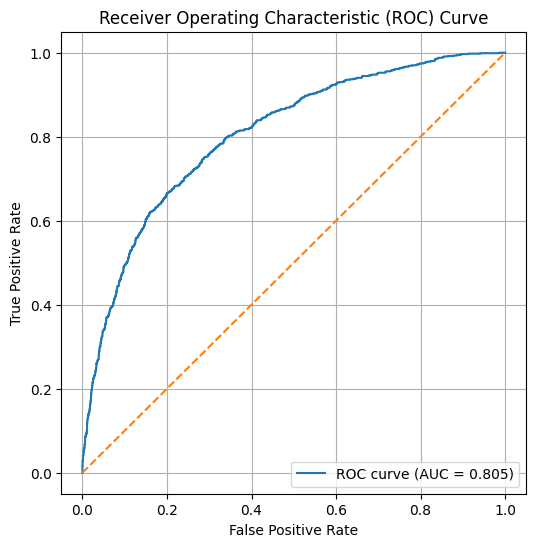

In [31]:
idx_tpr = np.argmax(tpr)
idx_fpr = np.argmin(fpr)

idx = idx_tpr
best_thresh = thresholds[idx]

# print(f"TPR = {tpr[idx]:.2f} | FPR: {fpr[idx]:.2f}")
# print(f"Best Threshold Value: {best_thresh:.2f}")

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()